# SVM Classification Using Individual Replicas
This notebook analyzes the quality of the classifiers resulting from training on individual replicas of read counts rather than averaged values. Data are adjusted for library size and gene length.

In [1]:
import init
from common import constants as cn
from common.trinary_data import TrinaryData
from common.data_provider import DataProvider
from common_python.plots import util_plots
from plots import util_plots as xutil_plots
from common_python.classifier import classifier_ensemble
from common_python.classifier import classifier_collection
from common_python.classifier.classifier_ensemble_random_forest import ClassifierEnsembleRandomForest
from common_python.plots import util_plots as common_plots

import collections
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import PCA
from sklearn import svm
from sklearn.model_selection import cross_val_score

%matplotlib inline

## Analyze Replica Data
The following shows the extent to which replicas agree with the tranary values that are assigned.

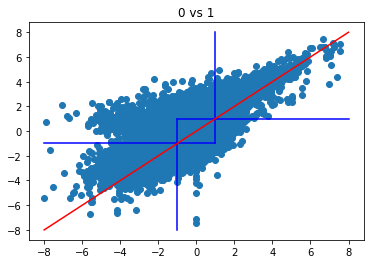

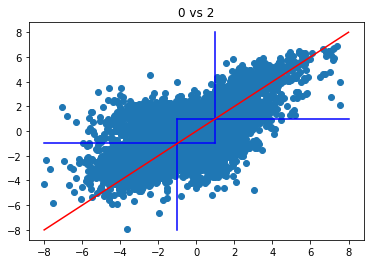

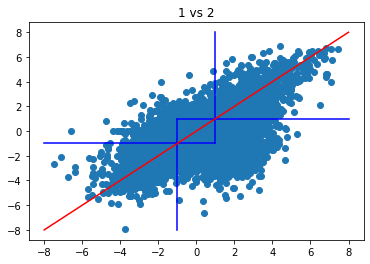

In [2]:
def compareDFValues(df1, df2, title):
    RANGE = [-8, 8]
    plt.figure()
    arr1 = df1.values.flatten()
    arr2 = df2.values.flatten()
    plt.scatter(arr1, arr2)
    # Define region of 0 values
    plt.plot([-1, -1], [-1, 1], color="b")
    plt.plot([1, 1], [-1, 1], color="b")
    plt.plot([-1, 1], [-1, -1], color="b")
    plt.plot([-1, 1], [1, 1], color="b")
    # Define region of 1 values
    plt.plot([1, 1], [1, RANGE[1]], color="b")
    plt.plot([1, RANGE[1]], [1, 1], color="b")
    # Define region of -1 values
    plt.plot([-1, -1], [-1, RANGE[0]], color="b")
    plt.plot([-1, RANGE[0]], [-1, -1], color="b")
    plt.plot(RANGE, RANGE, color="r")
    plt.title(title)
    
provider = DataProvider()
provider.do()
dfs = []
for idx in range(3):
      dfs.append(provider.dfs_adjusted_read_count_wrtT0_log2[idx])
compareDFValues(dfs[0], dfs[1], "0 vs 1")
compareDFValues(dfs[0], dfs[2], "0 vs 2")
compareDFValues(dfs[1], dfs[2], "1 vs 2")
    

In [3]:
dfs[0].values.flatten()


array([ 0.        ,  0.10046526,  0.38050473, ...,  0.03536785,
       -1.08206371, -0.74372999])

## SVM With Replicas

In [4]:
provider = DataProvider(is_normalized_wrtT0=True)
provider.do()
for n in range(3):
    print(provider.dfs_adjusted_read_count_wrtT0[n].head())

         T0.0      T1.0      T2.0      T3.0      T4.0      T5.0      T6.0  \
Rv0001    1.0  1.072119  1.301797  1.255190  1.353351  1.274508  0.919210   
Rv0005    1.0  1.637825  1.730923  2.040822  1.984227  1.989241  1.762261   
Rv0006    1.0  1.628194  1.519583  1.936701  1.928850  1.580781  1.886713   
Rv0009    1.0  1.959713  2.390467  1.762375  2.045719  2.008867  1.793311   
Rv0010c   1.0  1.378715  1.160466  1.171577  1.136251  1.267012  1.108681   

             T7.0      T8.0      T9.0  ...     T16.0     T17.0     T18.0  \
Rv0001   1.035712  0.886113  0.764993  ...  1.563982  1.154330  1.396935   
Rv0005   1.936669  0.991634  1.737733  ...  1.529332  0.867944  1.185441   
Rv0006   1.941937  0.752407  1.766990  ...  1.124146  0.692071  1.033188   
Rv0009   1.764238  0.707191  1.642490  ...  0.877297  0.545770  0.691607   
Rv0010c  1.048403  0.656563  0.844574  ...  0.672185  0.488660  0.488790   

            T19.0     T20.0     T21.0     T22.0     T23.0     T24.0     T25.0  


In [13]:
def clfEval(is_averaged):
    size = 50
    trinary = TrinaryData(is_averaged=is_averaged)
    df_X = trinary.df_X
    df_X.columns = trinary.features
    #
    svm_ensemble = classifier_ensemble.ClassifierEnsemble(
        classifier_ensemble.ClassifierDescriptorSVM(), size=size,
        classes=list(ser_y.values))
    return classifier_ensemble.ClassifierEnsemble.crossValidateByState(
        svm_ensemble, df_X, trinary.ser_y, size)

In [6]:
clfEval(True)

CrossValidationResult(mean=0.27952, std=0.13273887750015065, collection=<common_python.classifier.classifier_ensemble.ClassifierEnsemble object at 0x7fcd1bf27460>)

In [14]:
clfEval(False)

CrossValidationResult(mean=0.44615999999999995, std=0.1816549872698242, collection=<common_python.classifier.classifier_ensemble.ClassifierEnsemble object at 0x7fcd19a80af0>)

Isn't selecting enough indices or randomizing them.

### Do Cross Validation Manually to Discover Cause of Poor Fits

In [30]:
def simpleTest(is_averaged, test_size=10, num_iterations=5):
    # Choose random observations for cross validation
    trinary = TrinaryData(is_averaged=is_averaged, is_dropT1=False)
    trinary.df_X.head()
    df_X = trinary.df_X.copy()
    df_X.columns = trinary.features
    ser_y = trinary.ser_y
    full_size = len(df_X)
    train_size = full_size - test_size
    results = []
    for _ in range(num_iterations):
        indices = np.random.permutation(df_X.index)
        train_indices = indices[0:train_size]
        test_indices = indices[train_size: full_size]
        svm_ensemble = classifier_ensemble.ClassifierEnsemble(
                classifier_ensemble.ClassifierDescriptorSVM(), size=30,
                classes=list(ser_y.values))
        svm_ensemble.fit(df_X.loc[train_indices, :], ser_y.loc[train_indices])
        results.append(svm_ensemble.score(df_X.loc[train_indices, :], ser_y.loc[train_indices]))
    return np.mean(results), np.std(results)

In [31]:
simpleTest(True)

(0.9542222222222222, 0.005370242654930917)

In [25]:
simpleTest(False)

(0.9939487179487179, 0.0006803332903293331)

Why does cross validate give such a low score?

In [47]:
# Cross validation with one holdout per state
def simpleStateCrossValidation(is_averaged, num_iterations=10):
    NUM_HOLDOUTS = 1
    trinary = TrinaryData(is_averaged=is_averaged, is_dropT1=False)
    trinary.df_X.head()
    df_X = trinary.df_X.copy()
    df_X.columns = trinary.features
    ser_y = trinary.ser_y
    states = list(set(ser_y.values))
    results = []
    for _ in range(num_iterations):
        test_indices = []
        for state in states:
            ser_sample = ser_y[ser_y == state].sample(n=NUM_HOLDOUTS)
            test_indices.extend(list(ser_sample.index))
        train_indices = list(set(df_X.index).difference(test_indices))
        svm_ensemble = classifier_ensemble.ClassifierEnsemble(
                classifier_ensemble.ClassifierDescriptorSVM(), size=30,
                classes=list(ser_y.values))
        svm_ensemble.fit(df_X.loc[train_indices, :], ser_y.loc[train_indices])
        results.append(svm_ensemble.score(df_X.loc[test_indices, :], ser_y.loc[test_indices]))
    return np.mean(results), np.std(results)
#df_predict = svm_ensemble.predict(df_X.loc[test_indices, :])

In [49]:
simpleStateCrossValidation(False)

(0.5833333333333333, 0.12067198678675067)

In [46]:
simpleStateCrossValidation(True)

(0.2286666666666667, 0.09784568349077939)

**Observations**
1. Unclear why accuracy dropped from where it was.
1. Some classes are more difficult to predict?
1. Now getting consistent results between state-based cross validation and that done by hand.
1. Does is_drop_T1 option handle df_X?
1. Accuracy analysis by state
   1. Bar plot of distribution of states
   1. Calculate accuracy by state
   1. Plot #obs vs. accuracy
1. Other todos
   1. Check with old notebooks to see why such lower accuracies
   1. Feature selection?
   1. Show genes responsible by state
   1. One-vs-next analysis
   

In [ ]:
ser_y[test_indices]

In [ ]:

def isConsistentState(ser):
    # Check consistency of states
    df = pd.DataFrame()
    df["state"] = ser
    df["time"] = [t.split(".")[0] for t in ser_y.index]
    df_g = df.groupby("time")
    ser_g = df_g.apply(lambda g: len(set(g["state"])))
    if len(ser_g[ser_g > 1]) > 0:
        import pdb; pdb.set_trace()
    
isConsistentState(ser_y)

In [ ]:
type(df_g.apply(lambda g: len(set(g["state"]))))

In [ ]:
type(df_g.std())

Problem: Incorrect assignment of state values to times. T17.2 shouldn't be 0.

In [ ]:
ser_y[test_indices]

In [ ]:
for idx in test_indices:
    print("%s: %d" % (idx, ser_y[idx]))

In [ ]:
for idx in ser_y.index:
    print("%s: %d" % (idx, ser_y[idx]))

In [ ]:
classifier_ensemble.ClassifierEnsemble.crossValidateByState(
        svm_ensemble, df_X, ser_y, num_clfs=20)

In [ ]:
common_plots.plotTrinaryHeatmap(df_X.T)

In [ ]:
ser_y